In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import tqdm
from IPython import display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
plt.rcParams['figure.dpi'] = 300

In [18]:
# первое начальное условие из примера задачи u(x, y, 0): 
def phi(x, y, a, b):
	return np.arctan(np.cos(np.pi * x / a))

# второе начальное условие из примера задачи dudt(x, y, 0): 
def psi(x, y, a, b):
	return np.sin(2 * np.pi * x / a) * np.sin(np.pi * y / b)

# тестовая функция (первое начальное условие - u(x, y, 0))
def testphi(x, y, a, b):
	return np.zeros((x.shape[0], y.shape[1]))

# тестовая функция (второе начальное условие - dudt(x, y, 0))
def testpsi(x, y, a, b):
	n = m = 1
	nu = 2 * np.pi * n / a
	mu = 2 * np.pi * m / b
	# lambda = nu + mu
	k = np.sqrt(nu ** 2 + mu ** 2)
	# return np.sin(nu * x) * np.cos(mu * y) # тестовый пример 1
	return np.sin(nu * x) * np.cos(mu * y) + np.sin(2 * nu * x) * np.cos(2 * mu * y)
	
# тестовый пример - функция u(x, y, t)
def testU(x, y, t, a, b):
	n = m = 1
	nu = 2 * np.pi * n / a
	mu = 2 * np.pi * m / b
	# lambda = nu + mu
	k = np.sqrt(nu ** 2 + mu ** 2)
	# return (1 / k) * np.sin(nu * x) * np.cos(mu * y) * np.sin(k * t) # тестовый пример 1
	return (1 / k) * np.sin(nu * x) * np.cos(mu * y) * np.sin(k * t) + (1 / (2*k)) * np.sin(2 * nu * x) * np.cos(2 * mu * y) * np.sin(2 * k * t) # тестовый пример 2

In [3]:
# класс, решающий задачу
class SolverVec:
	u = None
	def __init__(self, a, b, step, ut0, dudt0):
		self.a = np.float64(a)
		self.b = np.float64(b)
		self.dx = np.float64(step)
		self.dy = np.float64(step)
		self.nodes_x = int(self.a / self.dx)
		self.nodes_y = int(self.b / self.dy)
		x = np.linspace(-self.a/2, self.a/2, self.nodes_x, dtype='float64')
		y = np.linspace(-self.b/2, self.b/2, self.nodes_y, dtype='float64')
		self.x, self.y = np.meshgrid(x, y)
		print(self.x.shape)
		print(self.y.shape)
		self.I = ut0
		self.V = dudt0
		self.invdxsq = 1 / (self.dx ** 2)
		self.invdysq = 1 / (self.dy ** 2)
	
	# вторая производная по x
	def uxx(self, first_step):
		u = self.u0 if first_step else self.u1
		uxx = np.zeros((u.shape[0], u.shape[1]))
		uxx[:, 1:-1] = (u[:, :-2] - 2 * u[:, 1:-1] + u[:, 2:]) * self.invdxsq
		return uxx

	# вторая производная по y
	def uyy(self, first_step):
		u = self.u0 if first_step else self.u1
		uyy = np.zeros((u.shape[0], u.shape[1]))
		uyy[0, :] = (2 * u[1, :] - 2 * u[0, :]) * self.invdysq
		uyy[-1, :] = (2 * u[-2, :] - 2 * u[-1, :]) * self.invdysq
		uyy[1:-1, :] = (u[:-2, :] - 2 * u[1:-1, :] + u[2:, :]) * self.invdysq
		return uyy

	# заполнение слоев t=0 и t=dt (используя начальные условия)
	def first_step(self, dt):
		self.u0 = self.I(self.x, self.y, self.a, self.b)
		uxx = self.uxx(True)
		uyy = self.uyy(True)
		psi = self.V(self.x, self.y, self.a, self.b)
		self.u1 = self.u0 + dt * psi + 0.5 * dt**2 * (uxx + uyy)

	# расчет нового временного слоя с шагом dt
	def advance(self, dt):
		if self.u is not None:
			self.u0 = self.u1
			self.u1 = self.u
		uxx = self.uxx(False)
		uyy = self.uyy(False)
		self.u = 2 * self.u1.copy() - self.u0.copy() + dt**2 * (uxx + uyy)
		return self.u

In [19]:
a = 2
b = 1
h = 0.01
dt = round(h*h/np.sqrt(h**2 + h**2), 7) - (1 * 1e-4)

print(f'Шаг по сетке: {h}')
print(f'Шаг по времени: {dt}')

Шаг по сетке: 0.01
Шаг по времени: 0.0069711


In [20]:
# инициализация класса и расчет первых двух слоев
solverVec = SolverVec(a, b, h, testphi, testpsi)
solverVec.first_step(dt)

(100, 200)
(100, 200)


In [21]:
# определяем погрешность
errList = []
maxU = []
maxSolv = []
observations = 100
t = 2 * dt
for i in tqdm.trange(2, observations + 2):
	u = solverVec.advance(dt)
	uTrue = testU(solverVec.x, solverVec.y, t, a, b)
	err = np.max(np.abs(u - uTrue))
	errList.append(err)
	maxU.append(np.max(np.abs(uTrue)))
	maxSolv.append(np.max(np.abs(u)))
	t += dt

100%|██████████| 100/100 [00:00<00:00, 812.08it/s]


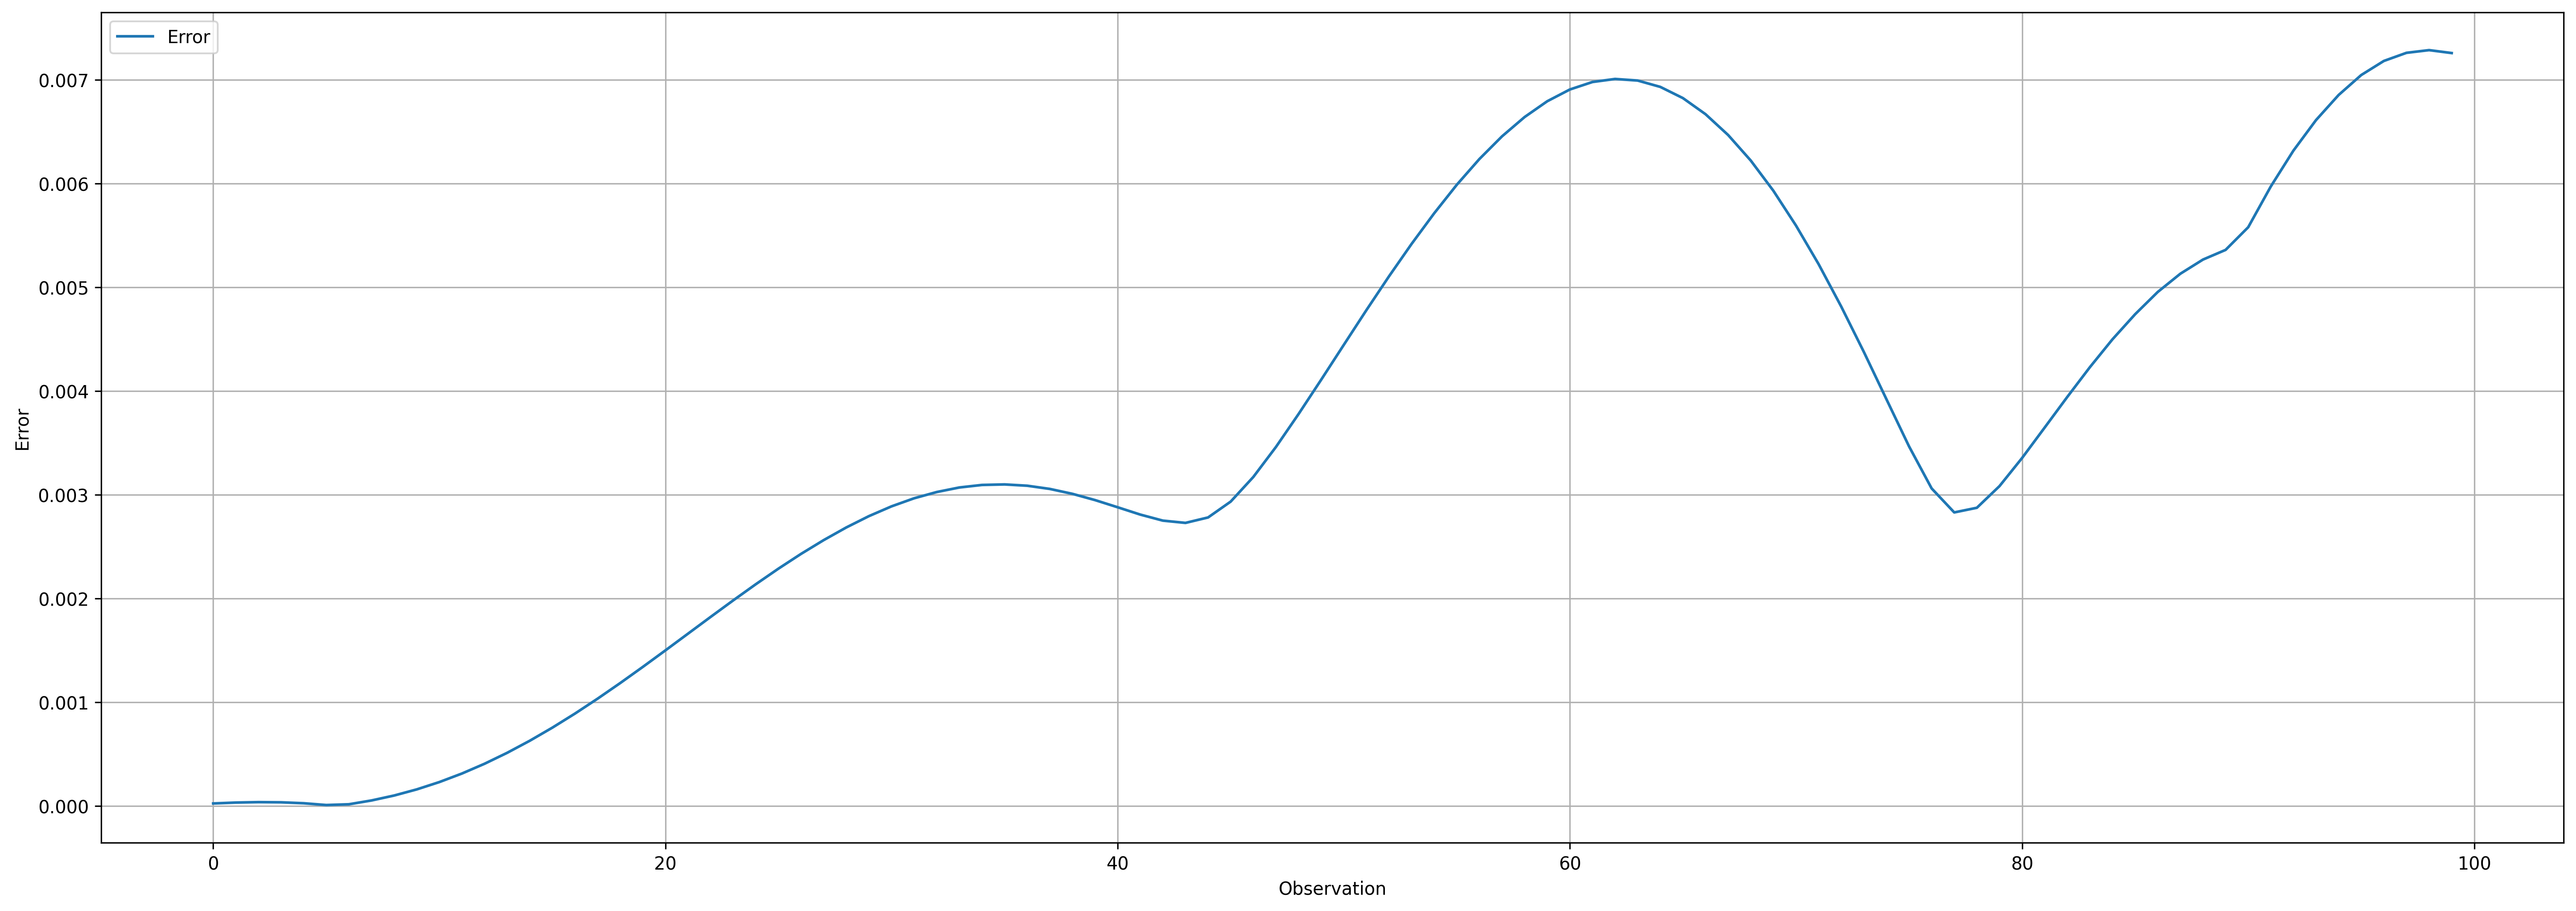

In [22]:
# отрисовка графика погрешности, максимума модуля точного и приближенного решения
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(20, 7))
axs.plot([i for i in range(observations)], [errList[i] for i in range(observations)], label='Error')
# axs.plot([i for i in range(observations)], [maxU[i] for i in range(observations)], label='True')
# axs.plot([i for i in range(observations)], [maxSolv[i] for i in range(observations)], label='Solver')
axs.set_xlabel('Observation')
axs.set_ylabel('Error')
axs.grid()
axs.legend()
plt.show()

In [ ]:
# создание анимации: приближенное решение 
solverVec = SolverVec(a, b, h, phi, psi)
solverVec.first_step(dt)

# определение количества кадров, длительности и прореживания
duration = 40
fps = 30
iterations = fps * duration + 1
drop = 4 # добавляем только каждый 4й слой

time_cube_solver = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1]))
start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube_solver[i//drop] = curU
print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')


idx = 0
# каждая отрисовка ~ <=40мс
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(solverVec.x, solverVec.y, time_cube_solver[idx], cmap='viridis', edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg


animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'final{1}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')

In [ ]:
# создание анимации: точное и приближенное решение
solverVec = SolverVec(a, b, h, testphi, testpsi)
solverVec.first_step(dt)

# определение количества кадров, длительности и прореживания
duration = 40
fps = 30
iterations = fps * duration + 1
drop = 4 # добавляем только каждый 4й слой

time_cube = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1]))
start = time.time()
t = dt*2
for i in tqdm.trange(iterations):
	if i % drop == 0: time_cube[i//drop] = testU(solverVec.x, solverVec.y, t, a, b)
	t += dt
print('Среднее время итерации:', (time.time() - start) / iterations)

time_cube_solver = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1])) # len(solverVec.y), len(solverVec.x)
start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube_solver[i//drop] = curU
print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15, 7), subplot_kw={'projection': '3d'})

idx = 0
# функция отрисовки графика (~ <=40мс)
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(solverVec.x, solverVec.y, time_cube[idx], cmap='viridis', edgecolor='none')
	ax2.clear()
	ax2.set_xlim(-a/2, a/2)
	ax2.set_ylim(-b/2, b/2)
	ax2.set_zlim(-1, 1)
	ax2.plot_surface(solverVec.x, solverVec.y, time_cube_solver[idx], cmap='viridis', edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg


animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'compare_final{3}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')